### Sentiment Analysis for Mental Health
Unlocking Mental Health Patterns through Statements

In [ ]:
# install wordcloud package
!pip install wordcloud

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud  # Now this will work
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import string
import joblib
import warnings
warnings.filterwarnings('ignore')

### 1. Data

- Require Text & Corresponding Label
- Health Conditions Data Collected from Kaggle

In [ ]:
# 1. Data
df = pd.read_csv(r"/kaggle/input/health/new.csv")

print(" Dataset Loaded Successfully!\n")
print(df.head())

 Dataset Loaded Successfully!

   Anxiety                                         oh my gosh
0  Anxiety  trouble sleeping, confused mind, restless hear...
1  Anxiety  All wrong, back off dear, forward doubt. Stay ...
2  Anxiety  I've shifted my focus to something else but I'...
3  Anxiety  I'm restless and restless, it's been a month n...
4  Anxiety  every break, you must be nervous, like somethi...


In [ ]:
# basic info
print("\n--- Dataset Information ---")
print(df.info())


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Anxiety     53041 non-null  object
 1   oh my gosh  52680 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB
None


In [5]:
print("\n--- Summary Statistics ---")
print(df.describe(include='all'))


--- Summary Statistics ---
       Anxiety         oh my gosh
count    53041              52680
unique       7              51068
top     Normal  what do you mean?
freq     16351                 22


In [6]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
Anxiety         2
oh my gosh    363
dtype: int64


In [6]:
print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Duplicate Rows ---
1948


In [7]:
# Display shape
print(f"\nDataset Shape: {df.shape}")


Dataset Shape: (53043, 2)


In [8]:
# manually set these if you know your dataset structure
text_col = 'oh my gosh'
sentiment_col = 'Anxiety'

# Auto-detect text column (most likely long string/text)
# for col in df.columns:
#     if df[col].dtype == 'object' and df[col].str.len().mean() > 20:
#         text_col = col
#         break

In [9]:
# Auto-detect sentiment column (if contains words like "positive"/"negative")
# for col in df.columns:
#     if df[col].dtype == 'object' and df[col].nunique() <= 5:
#         sentiment_col = col
#         break

In [10]:
print(f"\n🧩 Detected Text Column: {text_col}")
print(f"🧩 Detected Sentiment Column: {sentiment_col}")

if not text_col or not sentiment_col:
    raise ValueError("Please specify your text and sentiment columns manually!")


🧩 Detected Text Column: oh my gosh
🧩 Detected Sentiment Column: Anxiety


## Sentiment Distribution Visualization

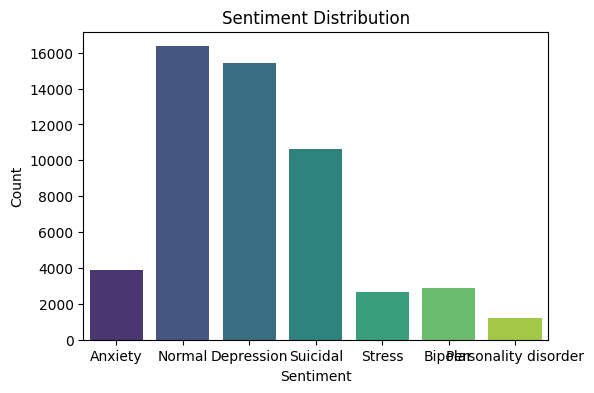

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x=sentiment_col, data=df, palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## 2.Text Cleaning Function

In [12]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)      # Remove URLs
    text = re.sub(r'<.*?>', '', text)                      # Remove HTML
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\d+', '', text)                        # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()               # Remove extra spaces
    return text

In [13]:
df['clean_text'] = df[text_col].apply(clean_text)

## EDA on Text Length

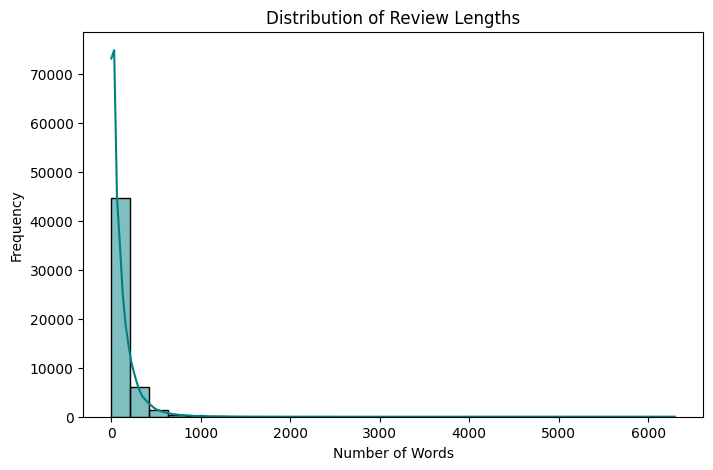

In [14]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=30, kde=True, color='teal')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

## WordCloud Visualization

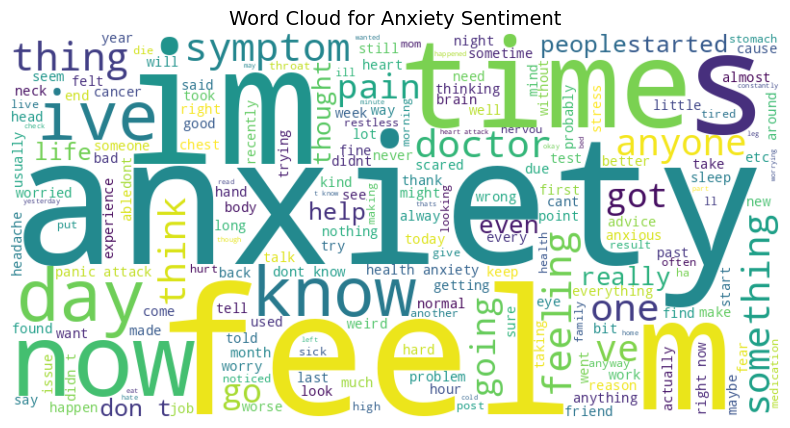

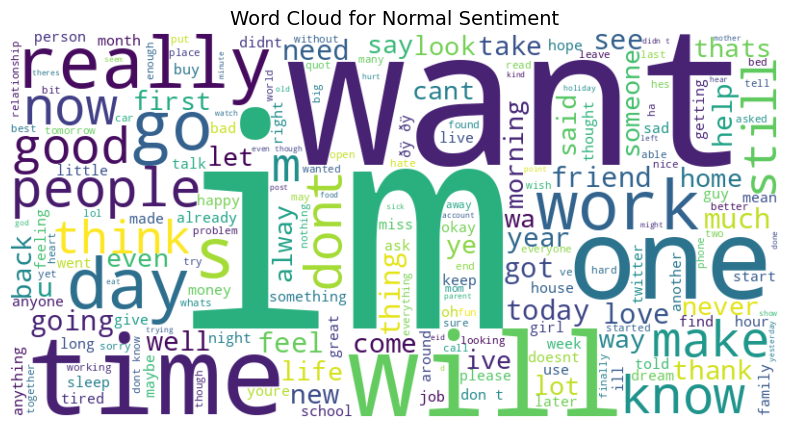

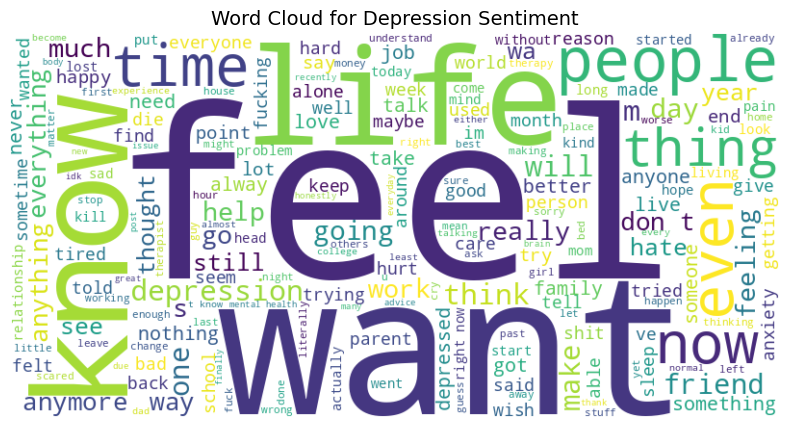

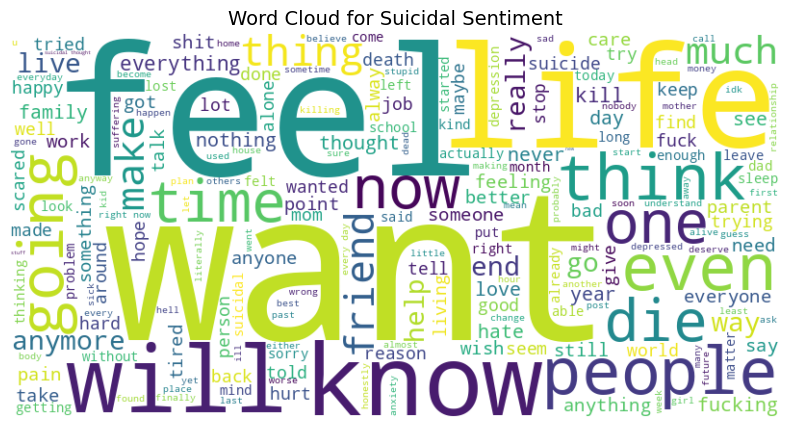

No text available for sentiment: nan


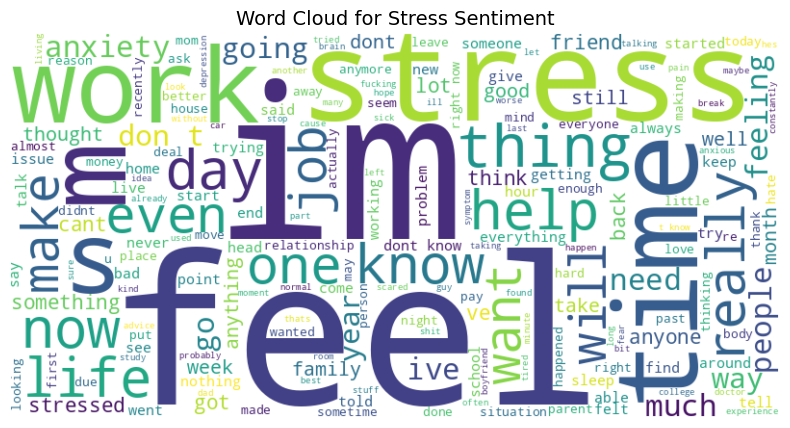

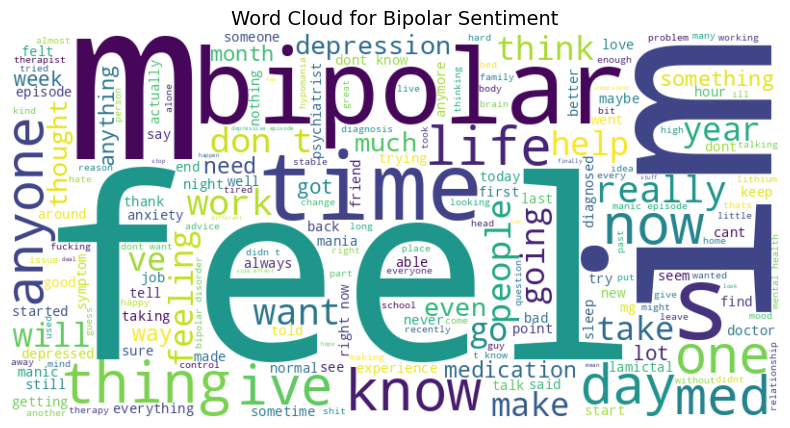

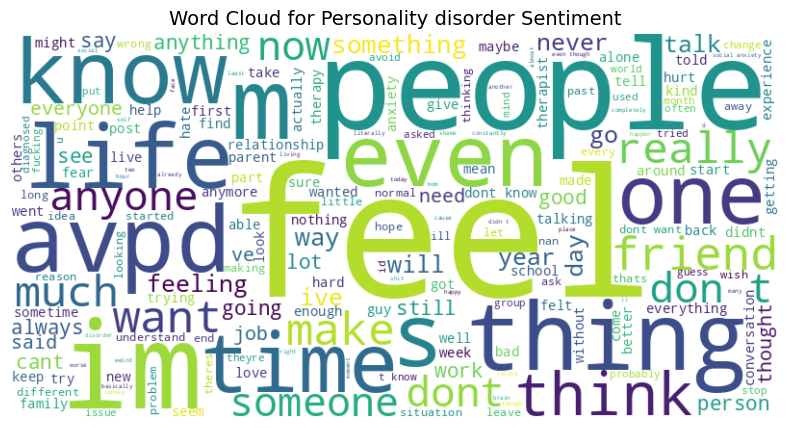

In [15]:
for label in df[sentiment_col].unique():
    subset = df[df[sentiment_col] == label].dropna(subset=['clean_text']) # Drop rows with empty clean_text
    text = " ".join(subset['clean_text'].values)
    if text: # Check if there is any text after dropping empty rows
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {label} Sentiment", fontsize=14)
        plt.show()
    else:
        print(f"No text available for sentiment: {label}") # Print message if no text for a label

## Most Frequent Words Visualization

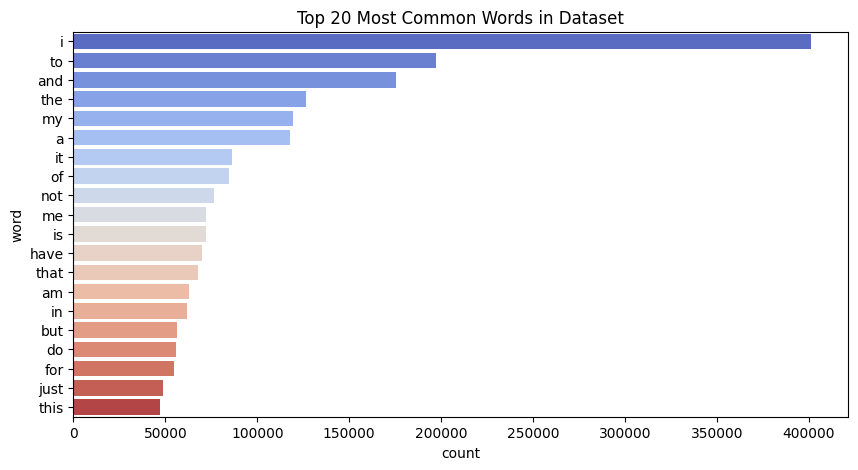

In [16]:
from collections import Counter

def get_top_n_words(corpus, n=20):
    words = " ".join(corpus).split()
    common_words = Counter(words).most_common(n)
    df_common = pd.DataFrame(common_words, columns=['word', 'count'])
    return df_common

common_df = get_top_n_words(df['clean_text'])
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=common_df, palette='coolwarm')
plt.title("Top 20 Most Common Words in Dataset")
plt.show()

##  Split Dataset

In [17]:
# Drop rows with missing values in either the text or sentiment columns
df_cleaned = df.dropna(subset=[text_col, sentiment_col, 'clean_text'])

X = df_cleaned['clean_text']
y = df_cleaned[sentiment_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Data Split Complete!")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


✅ Data Split Complete!
Train size: 42143, Test size: 10536


## TF-IDF Vectorization

In [18]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Matrix Shape: {X_train_tfidf.shape}")

TF-IDF Matrix Shape: (42143, 5000)


## Model Training (Logistic Regression)

In [19]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
print("\n✅ Model Training Complete!")


✅ Model Training Complete!


## Model Evaluation


🎯 Accuracy: 0.7672

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.81      0.74      0.77       768
             Bipolar       0.86      0.68      0.76       556
          Depression       0.70      0.75      0.72      3081
              Normal       0.85      0.96      0.90      3269
Personality disorder       0.83      0.45      0.58       215
              Stress       0.66      0.43      0.52       517
            Suicidal       0.70      0.66      0.68      2130

            accuracy                           0.77     10536
           macro avg       0.77      0.66      0.70     10536
        weighted avg       0.76      0.77      0.76     10536



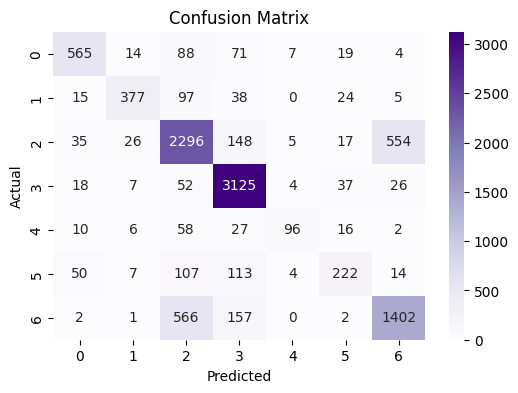

In [20]:
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Save Model and Vectorizer

In [21]:
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\n💾 Model and Vectorizer saved successfully!")


💾 Model and Vectorizer saved successfully!


## Predict Custom Input

In [23]:
def predict_sentiment(text):
    text_clean = clean_text(text)
    text_vec = vectorizer.transform([text_clean])
    return model.predict(text_vec)[0]

sample_text = "trouble sleeping, confused mind, restless hear"
print(f"\n🗣️ Sample Text: {sample_text}")
print(f"Predicted Sentiment: {predict_sentiment(sample_text)}")


🗣️ Sample Text: trouble sleeping, confused mind, restless hear
Predicted Sentiment: Anxiety
